In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt

import rksd.metrics as metrics
import rksd.kernels as kernels
import rksd.exp_utils as exp_utils

plt.rcParams["mathtext.fontset"] = "cm"

Testing $P=\mathcal{N}(0, 1)$ against $Q = (1-\epsilon)P + \epsilon R$, where $R = \mathcal{N}(10, 0.01^2)$ is a noise distribution.

In [2]:
np.random.seed(2024)

In [3]:
dim = 1
n = 500
ol = 10.
eps = 0.1

# assume standard Gaussian model
def score_fn(x):
    return -x

# pure sample
X = np.random.normal(size=(n, dim)) # n, d
score = score_fn(X)

# contaminated sample
ol_mean = np.ones((dim,1))[0] * ol
X_contam = exp_utils.sample_outlier_contam(np.copy(X), eps=eps, ol_mean=ol_mean, ol_std=0.01)
score_contam = score_fn(X_contam)

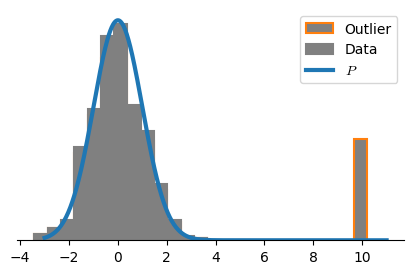

In [4]:
# plot data and model density
xvals = np.linspace(-3., ol_mean[0]+1., 1001)
norm_den = scipy.stats.norm.pdf(xvals)

_, ax = plt.subplots(figsize=(5, 3))
bins = np.histogram(X_contam, bins=25)[1]

ax.hist(X_contam.reshape(-1), bins, color="grey", density=True, edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(X.reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"$P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

#### robust-KSD test

In [5]:
# initialize kernel
weight_fn = kernels.PolyWeightFunction()                                # weighting function w(x)
base_kernel = kernels.IMQ(med_heuristic=True, X=X_contam, Y=X_contam)   # base kernel
kernel = kernels.TiltedKernel(kernel=base_kernel, weight_fn=weight_fn)  # tilted kernel

# initialize KSD
ksd = metrics.KSD(kernel)

The standard test has a small p-value due to the presence of contamination, while the robust-KSD test provably controls Type-I error whenever the allowed proportion of contamination $\epsilon_0$ is larger than or equal to the actual proportion of contamination.

In [6]:
eps0 = 0.15  # max proportion of contamination allowed

summary_contam = ksd.test_threshold(
    X=X_contam, 
    score=score_contam, 
    eps0=eps0,
    alpha=0.05, 
)
summary_contam

{'q_nonsq': Array(0.0781667, dtype=float32),
 'pval_standard': Array(0.00798403, dtype=float32),
 'vstat': Array(0.0123316, dtype=float32),
 'pval': Array(1., dtype=float32),
 'theta': Array(0.17990136, dtype=float32),
 'tau': Array(1.4384222, dtype=float32)}

In [7]:
print("p-values:")
print("Standard Tilted-KSD test:\t", summary_contam["pval_standard"])
print("Robust-KSD test:\t\t", summary_contam["pval"])

p-values:
Standard Tilted-KSD test:	 0.007984032
Robust-KSD test:		 1.0


If instead the actual proportion of contaminated samples is larger than the allowed proportion $\epsilon_0$, then robust-KSD will have a small p-value, showing its power.

In [8]:
summary_contam = ksd.test_threshold(
    X=X_contam, 
    score=score_contam, 
    eps0=0.01,
    alpha=0.05, 
)

print("p-values:")
print("Standard Tilted-KSD test:\t", summary_contam["pval_standard"])
print("Robust-KSD test:\t\t", summary_contam["pval"])

p-values:
Standard Tilted-KSD test:	 0.001996008
Robust-KSD test:		 0.00998004
